# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [116]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [117]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
../stanford-NLP/core already exists, skipping download
../stanford-NLP/postagger already exists, skipping download
../stanford-NLP/parser already exists, skipping download
../stanford-NLP/ner already exists, skipping download
Done setting up the Stanford NLP collection


We need to have stanford-NLP setup before importing, so we are doing the import here. IF you have stanford-NLP working, you can import at the beginning like you would with any other library.

In [118]:
import lucem_illud.stanford as stanford

Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we have defining our own `lucem_illud` function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `stanford.openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame. You can do this through links to the Stanford Core NLP project that we provide here, or play with their interface directly (in the penultimate cell of this notebook), which produces data in "pretty graphics" like this example parsing of the first sentence in the "Shooting of Trayvon Martin" Wikipedia article:

![Output 1](../data/stanford_core1.png)
![Output 2](../data/stanford_core2.png)

First, we will illustrate these tools on some *very* short examples:

In [119]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [120]:
pos_sents = stanford.postTagger.tag_sents(tokenized_text)
print(pos_sents)

[[('I', 'PRP'), ('saw', 'VBD'), ('the', 'DT'), ('elephant', 'NN'), ('in', 'IN'), ('my', 'PRP$'), ('pajamas', 'NNS'), ('.', '.')], [('The', 'DT'), ('quick', 'JJ'), ('brown', 'JJ'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')], [('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')], [('Trayvon', 'NNP'), ('Benjamin', 'NNP'), ('Martin', 'NNP'), ('was', 'VBD'), ('an', 'DT'), ('African', 'NNP'), ('American', 'NNP'), ('from', 'IN'), ('Miami', 'NNP'), ('Gardens', 'NNP'), (',', ','), ('Florida', 'NNP'), (',', ','), ('who', 'WP'), (',', ','), ('at', 'IN'), ('17', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('was', 'VBD'), ('fatally'

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [121]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col=0)

In [122]:
redditDF.loc[:10]

,author,over_18,score,subreddit,text,title,url
0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...
1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...
2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...
3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...
4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...
5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...
6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...
7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...
8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...
9,CopperD,False,9359,Tales From Tech Support,"A call comes in, a user reports her keyboard i...",nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn,https://www.reddit.com/r/talesfromtechsupport/...


Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word).

In [123]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[-5:]

,author,over_18,score,subreddit,text,title,url,sentences
4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened, ...], [So, ,, I, had, ..."
3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[[, Part, 1, ], (, http, :, //www.reddit.com/..."
1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -..."
0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [124]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [125]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NN), ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, R...
7    [[([, NNP), (Original, NNP), (Post, NNP), (], ...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBN), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, NNP), (Part, NNP), (1, CD), (], FW), ((,...
1    [[(>, JJR), ($, $), (Me, PRP), (-, :), (Hello,...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [126]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('(', 19),
 ('time', 14),
 (')', 14),
 ('lot', 12),
 ('computer', 12),
 ('email', 11),
 ('life', 11),
 ('**Genius**', 10),
 ('system', 9),
 ('message', 9),
 ('**Me**', 9),
 ('day', 9),
 ('office', 8),
 ('laptop', 8),
 ('part', 8),
 ('story', 8),
 ('today', 8),
 ('call', 8),
 ('user', 7)]

What about the number of top verbs (`VB`)?

In [127]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 18),
 ('have', 17),
 ('get', 14),
 ('do', 11),
 ('change', 9),
 ('make', 8),
 ('know', 7),
 ('say', 7),
 ('tell', 6),
 ('send', 6),
 ('look', 6),
 ('help', 6),
 ('go', 5),
 ('use', 4),
 ('want', 4),
 ('thank', 4),
 ('take', 4),
 ('work', 4),
 ('call', 4),
 ('open', 4)]

What about the adjectives that modify the word, "computer"?

In [128]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## Evaluating POS tagger

We can check the POS tagger by running it on a manually tagged corpus and identifying a reasonable error metric.

In [129]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [130]:
treeBank.sents()[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [131]:
stanfordTags = stanford.postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [132]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The Precision is {:.3f}%".format((total-NumDiffs)/total * 100))

Word: Dutch  	Stanford: JJ	Treebank: NNP
Word: publishing  	Stanford: NN	Treebank: VBG
Word: used  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: that  	Stanford: IN	Treebank: WDT
Word: later  	Stanford: RB	Treebank: JJ
Word: New  	Stanford: NNP	Treebank: JJ
Word: that  	Stanford: IN	Treebank: WDT
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: ago  	Stanford: RB	Treebank: IN
Word: replaced  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: JJ
Word: expected  	Stanford: VBD	Treebank: VBN
Word: study  	Stanford: VBD	Treebank: VBP
Word: studied  	Stanford: VBD	Treebank: VBN
Word: industrialized  	Stanford: JJ	Treebank: VBN
Word: Lorillard  	Stanford: NNP	Treebank: NN
Word: found  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT
Word: that  	Stanford: IN	Treebank: WDT
Word: rejected  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT

So we can see that the stanford POS tagger is quite good. Nevertheless, for a 20 word sentence, we only have a 66% chance ($1-.96^{20}$) of tagging (and later parsing) it correctly.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

The subset of project data that I am using in this assignment is 200 horror film plots that have showned after 2008 in the United States. The reason I am choosing to study horror film is because I am interested in studying: During the period of the Great Recession, were people more fond of horror films that feature monsters or horror films that feature people.

## Prepare for data

Load horror movies data set:

In [133]:
horror = pandas.read_csv('../data/horrorPlots.csv') 
horror.loc[:10]

,movie_id,title,year,plot
0,3280828,'Til Death,2011,As a newlywed mourns the loss of his late wife...
1,3280848,'Til Death Do Us Part,2011,Niko's a conman who knows his wife is unfaithf...
2,3281056,(AmI) Live,2011,In an interconnected world of intuitive techno...
3,3281283,*67,2011,A group of college students getting stalked by...
4,3281779,...With the Lights Out,2010,Even though Rachel's parents would never appro...
5,3281971,00:05'01,2008,"A scenic work about nature, human nature, and ..."
6,3282347,"1, 2, Z",2011,"It's the 50's, and instead of the Communists, ..."
7,3282410,1-800-Suicide,2009,The flashing red light of the phone blinds you...
8,3282994,100 Feet,2008,After seven years and fifty-two days in prison...
9,3283596,1013 Briar Lane,2009,"In 2008, a real-life mystery began to unfold w..."


To make a modest subset of corpus, take a random sample of 100 and reset its index.

In [134]:
horrorDF = horror.sample(500).reset_index()
horrorDF.iloc[:10]

,index,movie_id,title,year,plot
0,762,3805678,Huntsville,2010,A young girl goes missing during the night and...
1,1115,4160069,Paranormal Incident,2011,The infamous Odenbrook Sanitarium closed after...
2,1282,4272877,Sanctuary,2008,Two sisters have been hiding for over a year. ...
3,1259,4257378,Rose's Fable,2008,"After her parents passed away, Rose ('AnnaLaur..."
4,1746,4506289,The Raven,2010,This short film brings a new interpretation of...
5,829,3849591,It's Alive,2008,Pregnant college student Lenore Harker leaves ...
6,1883,4571401,Tragic,2009,Alfonso and Lucia Labella are expecting their ...
7,1616,4458959,The Haunting of Molly Hartley,2008,The bright atheist teenager Molly Hartley move...
8,1051,4102974,Nine Minute Love Song,2009,Claire is an eighteen year old girl from rural...
9,9,3283596,1013 Briar Lane,2009,"In 2008, a real-life mystery began to unfold w..."


Tokenizing the sentences                                                      

In [135]:
horrorDF['sentences'] = horrorDF['plot'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
horrorDF.iloc[:10]

,index,movie_id,title,year,plot,sentences
0,762,3805678,Huntsville,2010,A young girl goes missing during the night and...,"[[A, young, girl, goes, missing, during, the, ..."
1,1115,4160069,Paranormal Incident,2011,The infamous Odenbrook Sanitarium closed after...,"[[The, infamous, Odenbrook, Sanitarium, closed..."
2,1282,4272877,Sanctuary,2008,Two sisters have been hiding for over a year. ...,"[[Two, sisters, have, been, hiding, for, over,..."
3,1259,4257378,Rose's Fable,2008,"After her parents passed away, Rose ('AnnaLaur...","[[After, her, parents, passed, away, ,, Rose, ..."
4,1746,4506289,The Raven,2010,This short film brings a new interpretation of...,"[[This, short, film, brings, a, new, interpret..."
5,829,3849591,It's Alive,2008,Pregnant college student Lenore Harker leaves ...,"[[Pregnant, college, student, Lenore, Harker, ..."
6,1883,4571401,Tragic,2009,Alfonso and Lucia Labella are expecting their ...,"[[Alfonso, and, Lucia, Labella, are, expecting..."
7,1616,4458959,The Haunting of Molly Hartley,2008,The bright atheist teenager Molly Hartley move...,"[[The, bright, atheist, teenager, Molly, Hartl..."
8,1051,4102974,Nine Minute Love Song,2009,Claire is an eighteen year old girl from rural...,"[[Claire, is, an, eighteen, year, old, girl, f..."
9,9,3283596,1013 Briar Lane,2009,"In 2008, a real-life mystery began to unfold w...","[[In, 2008, ,, a, real-life, mystery, began, t..."


Create Part-of-Speech (POS) tagging of the corpus

In [136]:
horrorDF['POS_sents'] = horrorDF['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))
horrorDF.iloc[:10]

,index,movie_id,title,year,plot,sentences,POS_sents
0,762,3805678,Huntsville,2010,A young girl goes missing during the night and...,"[[A, young, girl, goes, missing, during, the, ...","[[(A, DT), (young, JJ), (girl, NN), (goes, VBZ..."
1,1115,4160069,Paranormal Incident,2011,The infamous Odenbrook Sanitarium closed after...,"[[The, infamous, Odenbrook, Sanitarium, closed...","[[(The, DT), (infamous, JJ), (Odenbrook, NNP),..."
2,1282,4272877,Sanctuary,2008,Two sisters have been hiding for over a year. ...,"[[Two, sisters, have, been, hiding, for, over,...","[[(Two, CD), (sisters, NNS), (have, VBP), (bee..."
3,1259,4257378,Rose's Fable,2008,"After her parents passed away, Rose ('AnnaLaur...","[[After, her, parents, passed, away, ,, Rose, ...","[[(After, IN), (her, PRP$), (parents, NNS), (p..."
4,1746,4506289,The Raven,2010,This short film brings a new interpretation of...,"[[This, short, film, brings, a, new, interpret...","[[(This, DT), (short, JJ), (film, NN), (brings..."
5,829,3849591,It's Alive,2008,Pregnant college student Lenore Harker leaves ...,"[[Pregnant, college, student, Lenore, Harker, ...","[[(Pregnant, JJ), (college, NN), (student, NN)..."
6,1883,4571401,Tragic,2009,Alfonso and Lucia Labella are expecting their ...,"[[Alfonso, and, Lucia, Labella, are, expecting...","[[(Alfonso, NNP), (and, CC), (Lucia, NNP), (La..."
7,1616,4458959,The Haunting of Molly Hartley,2008,The bright atheist teenager Molly Hartley move...,"[[The, bright, atheist, teenager, Molly, Hartl...","[[(The, DT), (bright, JJ), (atheist, NN), (tee..."
8,1051,4102974,Nine Minute Love Song,2009,Claire is an eighteen year old girl from rural...,"[[Claire, is, an, eighteen, year, old, girl, f...","[[(Claire, NNP), (is, VBZ), (an, DT), (eightee..."
9,9,3283596,1013 Briar Lane,2009,"In 2008, a real-life mystery began to unfold w...","[[In, 2008, ,, a, real-life, mystery, began, t...","[[(In, IN), (2008, CD), (,, ,), (a, DT), (real..."


Export file to the data directory just in case:

In [218]:
horrorDF.to_csv('week7Data.csv', index = False)

### Examine the list of words associated with at least three different parts of speech.

In order to facilitate examining the list of words, a function called 'countType' is composed which would tag POS of the corpus and count the number of occurrences.

In [137]:
def countType(countTarget, corpusPOS, topNum):                                  
    targetCounts = {}                                                           
    for entry in corpusPOS:                                                     
        for sentence in entry:                                                  
            for ent, kind in sentence:                                          
                if kind != countTarget:                                         
                    continue                                                    
                elif ent in targetCounts:                                       
                    targetCounts[ent] += 1                                      
                else:                                                           
                    targetCounts[ent] = 1                                       
    sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
    return sortedTargets[:topNum] 

Recall: "NN" stands for noun, singular or mass. So after observing the top 20 noun from a corpus of 500 horror film plot summaries, I discovered life to be the noun that top from all nouns. I think this makes sense a lot as phrases including the noun life is numerous and frequently occurs in the films. The next several nouns to be night, man, house. It is interesting to observe that woman, death, family, killer, and friends are also among the top nouns occuring in horror movie plots. I think this is because most of the horror movies occur involving those subject matters. 

In [138]:
countType('NN', horrorDF['POS_sents'], 20)

[('life', 122),
 ('night', 104),
 ('man', 92),
 ('town', 89),
 ('film', 89),
 ('house', 82),
 ('time', 76),
 ('story', 69),
 ('way', 65),
 ('group', 63),
 ('death', 63),
 ('home', 61),
 ('world', 59),
 ('family', 56),
 ('horror', 51),
 ('day', 50),
 ('killer', 49),
 ('woman', 49),
 ('girl', 44),
 ('mother', 43)]

Recall: "JJ" stands for adjectives. So after observing the top 20 adjectives, we could see some common adjectives we would typically expect to see in a horror movie plot, and those adjectives include "mysterious", "dark", "strange", "dead", and "terrifying". Meanwhile, there are some strange ones, such as "young", "next", "short", "true", "real", etc. that I could not associate with the actual movie content. 

In [139]:
countType('JJ', horrorDF['POS_sents'], 20)

[('young', 85),
 ('new', 64),
 ('old', 49),
 ('own', 48),
 ('dark', 45),
 ('small', 43),
 ('next', 41),
 ('local', 41),
 ('mysterious', 39),
 ('human', 36),
 ('other', 36),
 ('only', 35),
 ('first', 32),
 ('strange', 31),
 ('dead', 31),
 ('last', 29),
 ('true', 25),
 ('evil', 25),
 ('short', 25),
 ('real', 23)]

Recall: "PRP" stands for personal pronouns. It could be sees that from the 500 horror movie plots, the most frequently used personal pronoun is "he", followed by "they", and then followed by "it" with the last to be "she". It is interesting to see that "he" is actually the most frequently occurred personal pronouns as it indicates in those 500 sampled horror movies, males are typically the leading characters. From the frequencies of "he" and "she", we could also deduce that males are more frequently occurring in horror films than females. This gender bias is further validated by the number of occurrences of "him" and "her" with "him" occurring approximately 70 times more than "her". 

In [140]:
countType('PRP', horrorDF['POS_sents'], 20)

[('he', 341),
 ('they', 281),
 ('it', 200),
 ('she', 195),
 ('him', 170),
 ('them', 110),
 ('her', 106),
 ('He', 81),
 ('you', 67),
 ('They', 54),
 ('It', 51),
 ('She', 37),
 ('himself', 32),
 ('herself', 20),
 ('themselves', 19),
 ('we', 17),
 ('I', 14),
 ('You', 13),
 ('us', 12),
 ('itself', 8)]

### Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest)

In order to facilitate examining the conditional frequencies of choice, a function called 'conditionalFreq' is composed which show the conditional frequencies of choice:

In [141]:
def conditionalFreq(NTarget, corpusPOS, Word):                          
    NResults = set()                                                            
    for entry in corpusPOS:                                                     
        for sentence in entry:                                                  
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]): 
                if (kind1,ent2.lower())==(NTarget,Word):                        
                    NResults.add(ent1)                                          
                else:                                                           
                    continue                                                    
    return NResults

To test the effect of this function and the conditional frequency, I tried to see the adjectives associated with "zombie". It turns out the those adjectives include "apocalyptic", "half", and "unnamed". Those are all familiar adjectives that we would associate with zombies. 

In [142]:
conditionalFreq('JJ', horrorDF['POS_sents'], 'zombie')

{'apocalyptic',
 'bearded',
 'corporate',
 'few',
 'first',
 'half',
 'individual',
 'inevitable',
 'modern',
 'online',
 'unnamed'}

Next, I am interested in seeing if there is any differences between adjectives associated with "man" and "woman". So, it could be seen from the two cells below. In those 500 sampled horror films, there are more adjectives used to describe males than females. According to those adjectives, man are typically being described as crazy, such as "defective", "mad", "sadistic", "sick", "vicious", but powerful "handsome", "wealthy". On the other hand, females are typically associated with beautiful such as "mysterious", "perfect", "sexy", but also negative words such as"crazy", "evil", "headstrong", and "unsuspecting".

In [143]:
conditionalFreq('JJ', horrorDF['POS_sents'], 'man')

{'DEFECTIVE',
 'Defective',
 'depraved',
 'distraught',
 'free',
 'frightened',
 'handsome',
 'hapless',
 'homeless',
 'jealous',
 'last',
 'mad',
 'mysterious',
 'not-so-young',
 'old',
 'regular',
 'sadistic',
 'same',
 'sick',
 'toothless',
 'vicious',
 'wanted',
 'wealthy',
 'young'}

In [144]:
conditionalFreq('JJ', horrorDF['POS_sents'], 'woman')

{'French',
 'crazy',
 'evil',
 'gipsy',
 'headstrong',
 'mysterious',
 'paranoid',
 'perfect',
 'pregnant',
 'sexy',
 'unstable',
 'unsuspecting',
 'year-old',
 'young'}

After seeing the differences between man and woman, I am interested to explore if the gender bias/difference persist among young teenagers -- "boy" vs. "girl". Due to the size of the sample, there are not many adjectives available. There are several common ones as well, but also there are some distinctive ones. For boys, there are "ghostly", "dark", and "rich" while for girls, there are "beautiful", "opinionated", "servant". Interestingly, we could see that the gender bias persists even among the young generation.

In [145]:
conditionalFreq('JJ', horrorDF['POS_sents'], 'boy')

{'Dark', 'frat', 'ghostly', 'rich', 'strange', 'teenage', 'young'}

In [146]:
conditionalFreq('JJ', horrorDF['POS_sents'], 'girl')

{'beautiful',
 'little',
 'old',
 'opinionated',
 'regular',
 'religious',
 'servant',
 'teenage',
 'young'}

I am interested in seeing if there is any differences between adverbs associated with specific verbs such as "run" and "find". It is very interesting to observe that "run" is associated with "brutally" and "find" is associated with "soon", which matches our undertanding of horror movies: always escaping (running) and never find the truth until the last minute or too late.

In [160]:
conditionalFreq('RB', horrorDF['POS_sents'], 'run')

{'brutally'}

In [176]:
conditionalFreq('RB', horrorDF['POS_sents'], 'find')

{'soon'}

### What do these distributions suggest about your corpus?

The most interesting finding that I have summarized from my corpus of 500 horror movies is that there is obvious gender bias and differences. Fist, among personal pronouns, "he" is more frequently occurred than "she", and the same applies to "him" and "her". This order of frequencies show that in horror movie plots, males are more frequently described than females. 

In addition, I also assessed if there is any differences in terms of adjectives used to describe males and females. It turns out that regardless of age: "man" vs. "woman" or "boy" vs. "girl". Males are always associated with crazy and power while females are more closely associated with appearance and physicality. 

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [149]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
print(classified_sents)

[[('I', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'O'), ('in', 'O'), ('my', 'O'), ('pajamas', 'O'), ('.', 'O')], [('The', 'O'), ('quick', 'O'), ('brown', 'O'), ('fox', 'O'), ('jumped', 'O'), ('over', 'O'), ('the', 'O'), ('lazy', 'O'), ('dog', 'O'), ('.', 'O')], [('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')], [('Trayvon', 'PERSON'), ('Benjamin', 'PERSON'), ('Martin', 'PERSON'), ('was', 'O'), ('an', 'O'), ('African', 'O'), ('American', 'O'), ('from', 'O'), ('Miami', 'LOCATION'), ('Gardens', 'LOCATION'), (',', 'O'), ('Florida', 'LOCATION'), (',', 'O'), ('who', 'O'), (',', 'O'), ('at', 'O'), ('17', 'O'), ('years', 'O'), ('old', 'O'), (',', 'O'), ('was', 'O'), 

We can also run NER over our entire corpus:

In [150]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [151]:
redditTopScores['classified_sents']

9    [[(Last, O), (year, O), (,, O), (Help, O), (De...
8    [[(First, O), (post, O), (in, O), (quite, O), ...
7    [[([, O), (Original, O), (Post, O), (], O), ((...
6    [[(I, O), (witnessed, O), (this, O), (astoundi...
5    [[(I, O), (work, O), (Helpdesk, ORGANIZATION),...
4    [[(This, O), (just, O), (happened, O), (..., O...
3    [[(Another, O), (tale, O), (from, O), (the, O)...
2    [[([, O), (Part, O), (1, O), (], O), ((, O), (...
1    [[(>, O), ($, O), (Me, O), (-, O), (Hello, O),...
0    [[(So, O), (my, O), (story, O), (starts, O), (...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [152]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('.', 401),
 ('I', 245),
 ('the', 226),
 (',', 205),
 ('to', 197),
 ('a', 143),
 ('and', 135),
 ('>', 106),
 ('you', 102),
 ('of', 97)]

Or those occurring only twice:

In [153]:
[x[0] for x in sortedEntities if x[1] == 2]

['month',
 'working',
 'request',
 'absolutely',
 'order',
 'thinking',
 'holiday',
 'four',
 'visit',
 '60',
 'academic',
 'personally',
 'insurance',
 'There',
 'both',
 'guide',
 'S',
 'Of',
 'connection',
 'shortcut',
 'Everything',
 'random',
 'happiness',
 'yelled',
 'guy',
 'certain',
 'case',
 'tears',
 'glad',
 'DeskMugPhonePencil1',
 'supervisor',
 'Ca',
 'pages',
 'comments',
 'soon',
 'older',
 'ran',
 'lived',
 'discover',
 'systems',
 'slightly',
 'types',
 'error',
 'step',
 'calls',
 'operate',
 'command',
 'using',
 'spent',
 'stopped',
 'whom',
 'large',
 'computering',
 '*Are',
 'mistakes',
 'staff',
 'XYZ',
 'upside',
 'earlier',
 '*Note',
 'lunch',
 'favor',
 'drawer*',
 'BING',
 'ok',
 'course',
 'window',
 'Fail',
 'idea',
 'scenario',
 'completely',
 'box',
 'potential',
 '5',
 'making',
 'heard',
 'videos',
 'generate',
 'first',
 '17',
 'cry',
 'allowed',
 'gildings',
 'shaking',
 'While',
 'information',
 '100',
 'building',
 'live',
 'ago',
 'check',
 'retur

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [154]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 17),
 ('Google', 6),
 ('Smith', 5),
 ('Steve', 2),
 ('Reddit', 1),
 ('Boss', 1),
 ('Clickity', 1),
 ('GOOGLE', 1),
 ('CMD', 1),
 ('Nono', 1)]

What about the Organizations?

In [155]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Google', 6), ('Helpdesk', 1), ('Citrix', 1), ('GOOGLE', 1), ('CMD', 1)]

These, of course, have much smaller counts.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

Run Named-Entity Recognition (NER) on my corpus of 100 sampled horror film plots so as to identify named objects  

In [156]:
horrorDF = horrorDF.sample(100)
horrorDF['classified_sents'] = horrorDF['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [179]:
horrorDF['classified_sents'].iloc[:10]

241    [[('The, O), (Method, O), (', O), (is, O), (a,...
71     [[(Maine, LOCATION), (coastal, O), (town, O), ...
180    [[(It, O), ('s, O), (not, O), (uncommon, O), (...
130    [[(On, O), (the, O), (night, O), (of, O), (a, ...
233    [[(Dracula, O), ('s, O), (Daughter, O), (vs, O...
297    [[('Perfection, O), (', O), (is, O), (a, O), (...
239    [[(In, O), (Pierce, LOCATION), (County, LOCATI...
490    [[(The, O), (Violas, O), ((, O), (an, O), (all...
167    [[(Inspired, O), (by, O), (true, O), (accounts...
17     [[(A, O), (bloody, O), (,, O), (and, O), (grue...
Name: classified_sents, dtype: object

List all of the different kinds of entities tagged?

In [180]:
kinds = set()
for entry in horrorDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            kinds.add(kind)
kinds

{'LOCATION', 'O', 'ORGANIZATION', 'PERSON'}

### What does their distribution suggest about the focus of your corpus? 

To find the distributions of each category of tag, a function called 'tagDistribution' is composed to facilitate pattern recognition.

In [183]:
def tagDistribution(df, tagName, topNum):
    Counts = {}
    for entry in df['classified_sents']:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != tagName:
                    continue
                elif ent in Counts:
                    Counts[ent] += 1
                else:
                    Counts[ent] = 1
    sortedCounts = sorted(Counts.items(), key = lambda x: x[1], reverse = True)
    return sortedCounts[:topNum]

Find the distribution of Location category of tag: it could be seen that almost of all places of the location cateogries is in the U.S. and among which California seems to be the most "scary" place. It is interesting to see that California top the list and could an interesting research question to ask why California to be the place to be mentioned the most of the times in those sampled horror films?

In [184]:
tagDistribution(horrorDF, 'LOCATION', 20)

[('California', 4),
 ('America', 3),
 ('New', 3),
 ('Earth', 3),
 ('Iowa', 2),
 ('Spring', 2),
 ('Chicago', 2),
 ('Ohio', 2),
 ('Hills', 2),
 ('Texas', 2),
 ('Grove', 2),
 ('County', 2),
 ('Nowell', 1),
 ('Apartments', 1),
 ('Detroit', 1),
 ('Odenbrook', 1),
 ('Seattle', 1),
 ('Hopman', 1),
 ('Florida', 1),
 ('Bryn', 1)]

Find the distribution of 'O' category of tag:

In [185]:
tagDistribution(horrorDF, 'O', 20)

[('the', 488),
 (',', 461),
 ('.', 437),
 ('a', 320),
 ('and', 280),
 ('to', 271),
 ('of', 246),
 ('is', 145),
 ('in', 144),
 ('his', 100),
 ("'s", 77),
 ('her', 75),
 ('with', 71),
 ('their', 66),
 ('an', 63),
 ('that', 61),
 ('for', 61),
 ('who', 59),
 ('on', 57),
 ('he', 56)]

Find the distribution of organization category of tag and we could see that "FBI" is the most frequently occurred organization followed by "Church", "Club", and "Catholic". 

In [189]:
tagDistribution(horrorDF, 'ORGANIZATION', 20)

[('FBI', 4),
 ('&', 2),
 ('Church', 2),
 ('Insane', 1),
 ('Club', 1),
 ('Institute', 1),
 ('Catholic', 1),
 ('Samantha', 1),
 ('Hall', 1),
 ('the', 1),
 ('of', 1),
 ('Death', 1),
 ('Rubin', 1),
 ('Farm', 1),
 ('Russell', 1),
 ('SCA', 1),
 ('Birthday', 1),
 ('Angela', 1),
 ('Stanton', 1),
 ('Usher', 1)]

Find the distribution of person category of tag, we could see that the frequency of males names is more than the frequency of female names in genenral. Also, the number of male names is more than the number of female names. Thus, this finding confirmed our previous finding somehow that males is kind having a predominant role in horror films.

In [188]:
tagDistribution(horrorDF, 'PERSON', 20)

[('John', 12),
 ('Paul', 7),
 ('Angie', 6),
 ('Claire', 6),
 ('Welles', 5),
 ('Sam', 5),
 ('Jessica', 5),
 ('Simon', 5),
 ('Evelyn', 4),
 ('Fahey', 4),
 ('Braxton', 4),
 ('Madelyn', 4),
 ('Harry', 4),
 ('Brad', 4),
 ('Hoffman', 4),
 ('Ben', 4),
 ('Megan', 4),
 ('Toby', 4),
 ('William', 4),
 ('Dustin', 3)]

### For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

Taking a subset of the first five plots and store the automated tag of entities into a dataframe

In [195]:
autoDF = pandas.DataFrame()
for entry in horrorDF['classified_sents'][-5:]:
    for sentence in entry:
        for ent, kind in sentence:
            autoDF = autoDF.append([(ent, kind)], ignore_index = True)
autoDF = autoDF.rename(columns={0: "ent", 1: "kind"})
autoDF.to_csv('../data/auto.csv', index = False)
autoDF[:10]

,ent,kind
0,Do,O
1,you,O
2,like,O
3,blood,O
4,;,O
5,gore,O
6,?,O
7,Are,O
8,you,O
9,into,O


Load in hand-codings:

In [198]:
handDF = pandas.read_csv('../data/hand.csv', usecols = [0,2])
handDF.loc[:10]

,ent,hand
0,Do,O
1,you,O
2,like,O
3,blood,O
4,;,O
5,gore,O
6,?,O
7,Are,O
8,you,O
9,into,O


### Calculate the Precision, Recall and F-score for the NER classification

In [201]:
import sklearn
print('LOCATION:')
print('Precision:', sklearn.metrics.precision_score(handDF['hand'], autoDF['kind'] ,labels = ['LOCATION'], average = 'micro')) #precision
print('Recall:', sklearn.metrics.recall_score(autoDF['kind'], handDF['hand'], labels = ['LOCATION'], average = 'micro')) #recall
print('F-1 measure:', sklearn.metrics.f1_score(autoDF['kind'], handDF['hand'], labels = ['LOCATION'], average = 'micro')) #F-1 measure

LOCATION:
Precision: 1.0
Recall: 1.0
F-1 measure: 0.5


In [204]:
print('PERSON:')
print('Precision:', sklearn.metrics.precision_score(handDF['hand'], autoDF['kind'], labels = ['PERSON'], average = 'micro')) #precision
print('Recall:', sklearn.metrics.recall_score(autoDF['kind'], handDF['hand'], labels = ['PERSON'], average = 'micro')) #recall
print('F-1 measure:', sklearn.metrics.f1_score(autoDF['kind'], handDF['hand'], labels = ['PERSON'], average = 'micro')) #F-1 measure

PERSON:
Precision: 1.0
Recall: 1.0
F-1 measure: 0.625


# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [205]:
parses = list(stanford.parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Trayvon']), Tree('NNP', ['Benjamin']), Tree('NNP', ['Martin'])]), Tree('VP', [Tree('VBD', ['was']), Tree('NP', [Tree('NP', [Tree('DT', ['an']), Tree('NNP', ['African']), Tree('NNP', ['American'])]), Tree('PP', [Tree('IN', ['from']), Tree('NP', [Tree('NP', [Tree('NNP', ['Miami']), Tree('NNPS', ['Gardens'])]), Tree(',', [',']), Tree('NP', [Tree('NNP', ['Florida'])]), Tree(',', [',']), Tree('SBAR', [Tree('WHNP', [Tree('WP', ['who'])]), Tree('S', [Tree(',', [',']), Tree('PP', [Tree('IN', ['at']), Tree('ADJP', [Tree('NP', [Tree('CD', ['17']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])])]), Tree(',', [',']), Tree('VP', [Tree('VBD', ['was']), Tree('ADVP', [Tree('RB', ['fatally'])]), Tree('VP', [Tree('VBN', ['shot']), Tree('PP', [Tree('IN', ['by']), Tree('NP', [Tree('NP', [Tree('NNP', ['George']), Tree('NNP', ['Zimmerman'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['neighborhood']), Tree('NN', ['watch']), Tree('NN', [

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in is the relationship between different types of speech

In [206]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [207]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [208]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

[[('NP',
   'an African American from Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')],
 [('NP',
   'Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')]]

Notice that Florida occurs twice in two different nested noun phrases in the sentence. 

We can also find all of the verbs within the noun phrase defined by one or more target words:

In [209]:
treeSubRelation(fourthSentParseTree, 'NP', 'VBN', 'Florida', 'who')

{'shot'}

Or if we want to to look at the whole tree

In [210]:
fourthSentParseTree[0].pretty_print()

                                                                                                                   ROOT                                                                                                                       
                                                                                                                    |                                                                                                                          
                                                                                                                    S                                                                                                                         
            ________________________________________________________________________________________________________|_______________________________________________________________________________________________________________________   
           |                       VP     

Or another sentence

In [211]:
list(parses[1])[0].pretty_print()

                     ROOT                           
                      |                              
                      S                             
       _______________|___________________________   
      |                          VP               | 
      |                __________|___             |  
      |               |              PP           | 
      |               |      ________|___         |  
      NP              |     |            NP       | 
  ____|__________     |     |     _______|____    |  
 DT   JJ    JJ   NN  VBD    IN   DT      JJ   NN  . 
 |    |     |    |    |     |    |       |    |   |  
The quick brown fox jumped over the     lazy dog  . 



## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [271]:
text

['I saw the elephant in my pajamas.',
 'The quick brown fox jumped over the lazy dog.',
 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.',
 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.',
 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']

In [228]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x11da32d90>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [5]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'det',
                 'tag': 'DT',
                 'word': 'The'},
             2: {'address': 2,
                 'ctag': 'JJ',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'amod',
                 'tag': 'JJ',
                 'word

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another. We note that unless you have the graphviz successfully installed on your computer (which is not necessary to complete this homework), the following graphviz call will trigger an error. If you are interested in installing graphviz and working on a Mac, consider installing through [homebrew](https://brew.sh), a package manager (i.e., with the command "brew install graphviz", once brew is installed). 

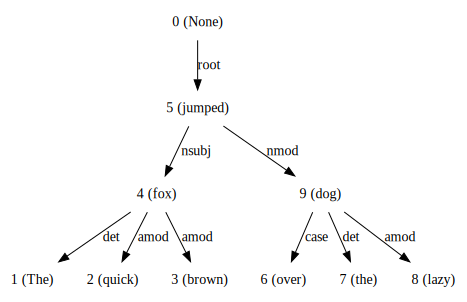

In [224]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

Or another sentence 

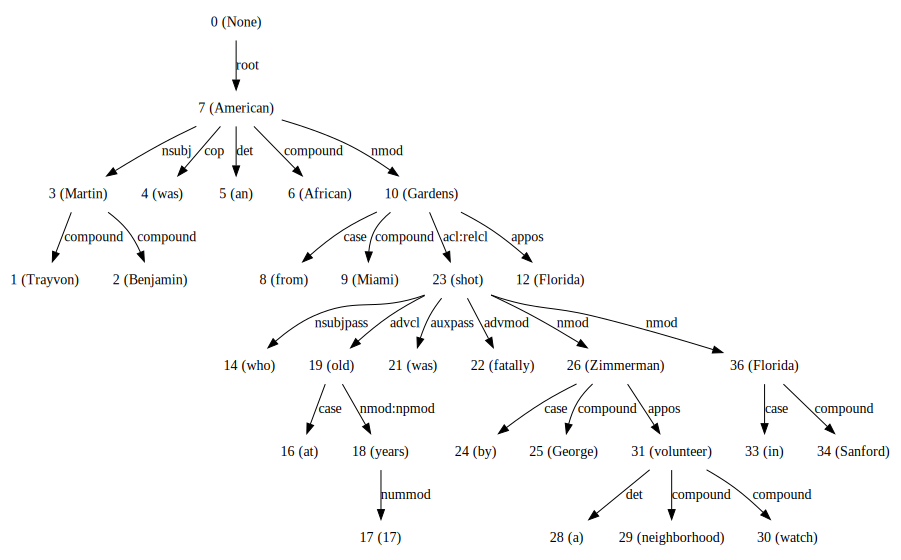

In [225]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

We can also do a dependency parse on the reddit sentences:

In [233]:
topPostDepParse = list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [234]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

So anyway , I get a call from an older gentleman who 's quite bitter and mean right off the bat ( does n't like that I asked for his address / telephone number to verify the account , hates that he has to speak with a machine before reaching an agent , etc . ) .


Which leads to a very rich dependancy tree:

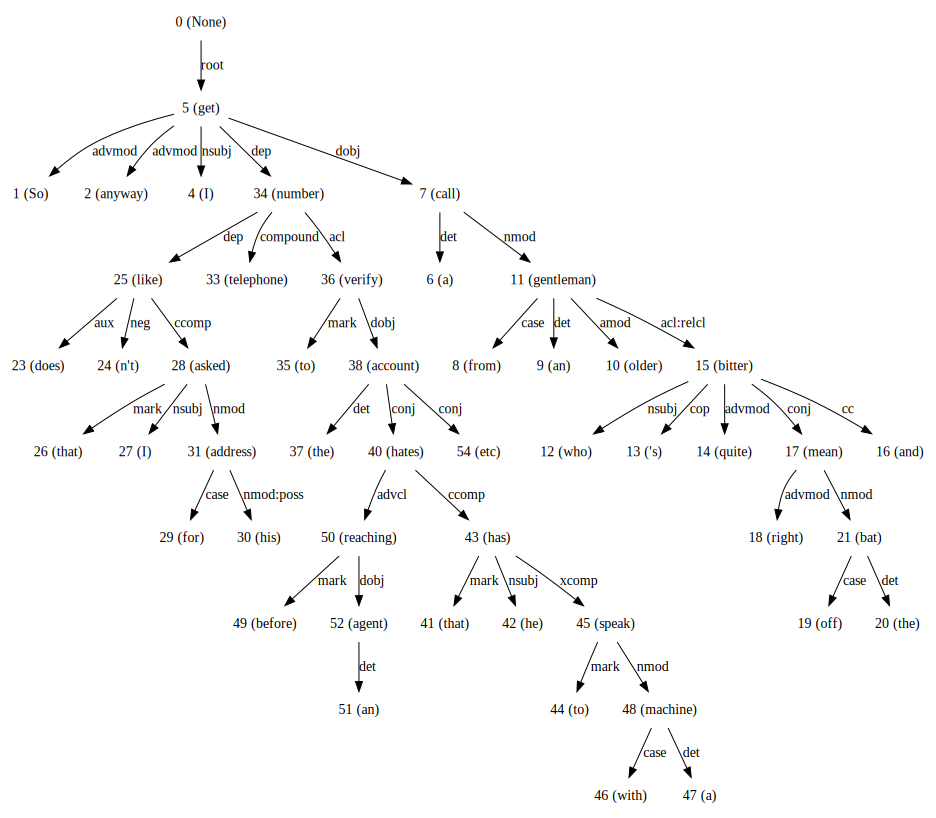

In [235]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

### Parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity?

I randomly chose to parse the eleventh plot summary in my horror film corpus. The complete plot summary is presented below:

In [278]:
horrorDF['plot'].iloc[10]

'When a gamer rolls seven critical failures in a row, this unknown to anyone, is an invocation that summons a minor demon from hell who is now free to roam the convention in an attempt to earn her horns by tempting people into sin. She has to get 10 points, and during a conversation with a fellow demon on her hell phone gets her first point by telling a mother her baby is ugly and causing her to hate it. A man in a bar finds the iPhone prototype and rather than return it, the demon suggests in his ear that he could make a lot of money by selling it to Gizmodo. She angers Guest of Honor Peter S. Beagle by telling him that his panel has been replaced by "Twilight" filking. She stands behind a SCA braggart with a sign saying, "Liar." An attempt to get a nerdy fan to pick up a girl by slapping her on the ass goes wrong when the girl likes it and they begin kissing passionately. The demon loses points and cannot believe it. Trying to encourage a goth girl to kill herself fails as well and e

Parse the text:

In [303]:
horror10Parse = list(stanford.depParser.parse_sents(horrorDF['sentences'].iloc[10]))

Look at the plot summary sentence by sentence:

In [304]:
print(' '.join(horrorDF['sentences'].iloc[10][0]))

When a gamer rolls seven critical failures in a row , this unknown to anyone , is an invocation that summons a minor demon from hell who is now free to roam the convention in an attempt to earn her horns by tempting people into sin .


Parsing initiation and take a look at the dependency tree: a 10-layer tree that is constructed from the sentence given.

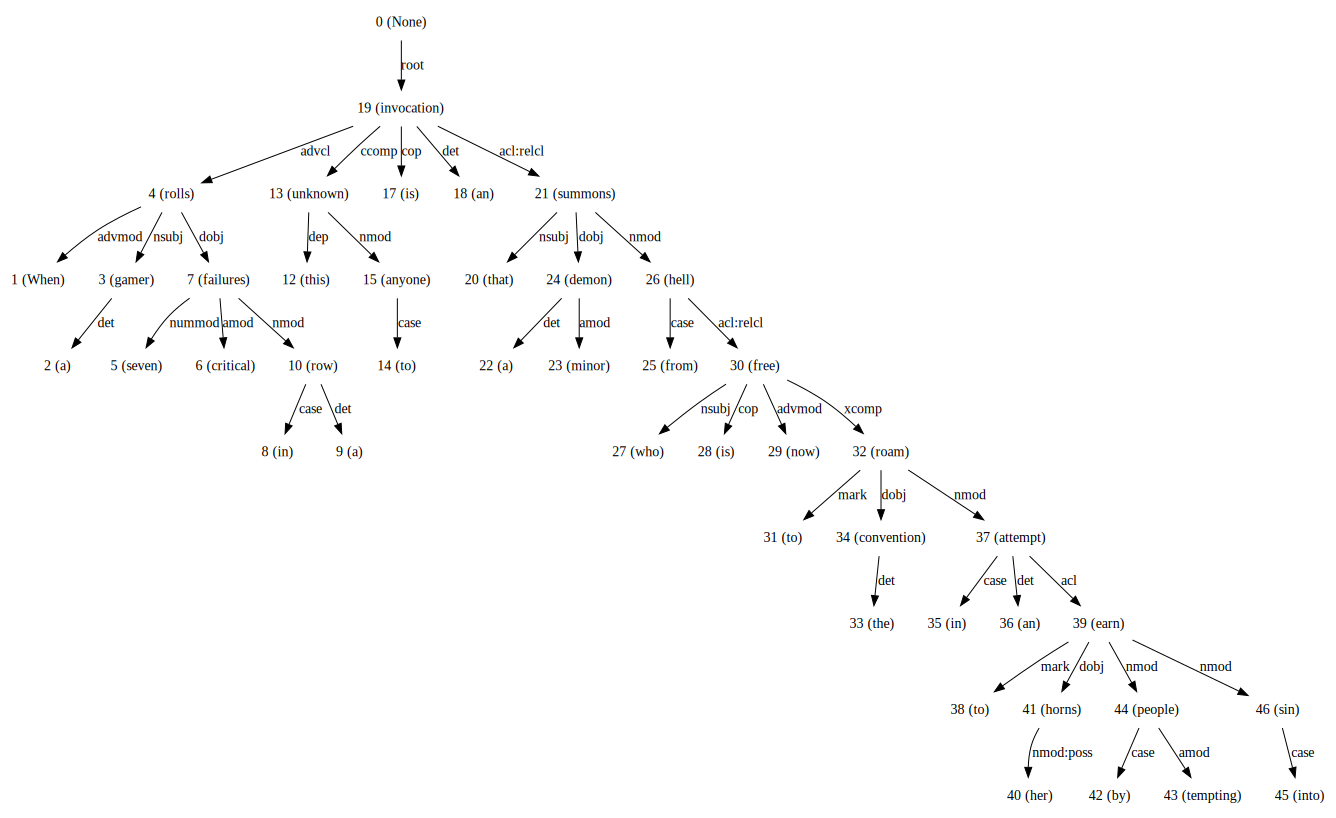

In [305]:
graph = graphviz.Source(list(horror10Parse[0])[0].to_dot())
graph

In the same plot summary, I will try to parse the second sentence:

In [306]:
print(' '.join(horrorDF['sentences'].iloc[10][1]))

She has to get 10 points , and during a conversation with a fellow demon on her hell phone gets her first point by telling a mother her baby is ugly and causing her to hate it .


Look at the dependency tree of the same plot but the second sentences: for the second sentence, it is relatively shorter and thus have 8 layers.

In [307]:
horror10Parse = list(stanford.depParser.parse_sents(horrorDF['sentences'].iloc[10]))

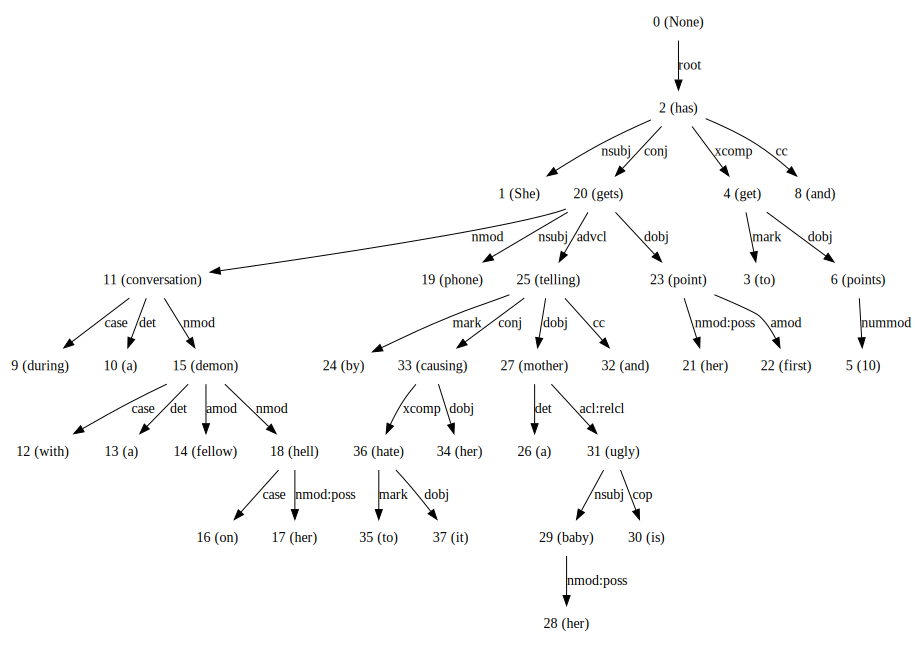

In [308]:
graph = graphviz.Source(list(horror10Parse[1])[0].to_dot())
graph

I randomly choose another number, so this time, I will parse the twentieth plot summary in my horror film corpus.

In [255]:
horror20Parse = list(stanford.depParser.parse_sents(horrorDF['sentences'].iloc[20]))

Briefly review the text again, and we could see this time its a relatively shorter and simpler sentence.

In [254]:
print(' '.join(horrorDF['sentences'].iloc[20][0]))

It 's always just a party- until somebody gets killed !


Looking at the dependency tree, we see that for this simple sentence, the layer is significantly smaller and has become 4 layers only.

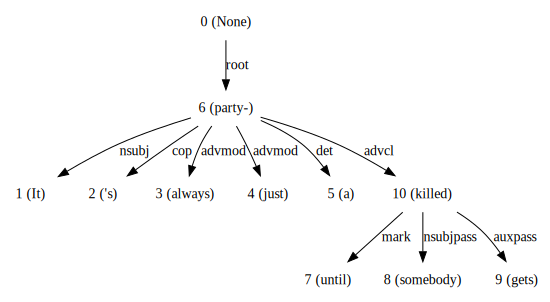

In [256]:
graphviz.Source(list(horror20Parse[0])[0].to_dot())

In conclusion, we could claim the parse depth is positively related to the sentence complexity. The greater the path depth, the more the sentence complexity, or the less parse depth, the simplier the sentence complexity. 

### What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

From these parses, I can extract nouns collocated in a noun phrase, adjectives that modify a noun, verbs related to a noun, nouns related to an adjective, and adverbs that modify a verb. 

I will first try to parse the whole dataset and attempt to capture these sets of things for some words to see what we can find.

In [312]:
horrorTree = []
for i in range(len(horrorDF['sentences'])):
    horrorParses = list(stanford.parser.parse_sents(horrorDF['sentences'].iloc[i]))
    for j in range(len(horrorParses)):
        HorrorSentParseTree = list(horrorParses[j]) 
        horrorTree += HorrorSentParseTree

To facilitate the process, two functions would be created: 'findRelation' is created to find part of the speech related to the targets and 'findSubrelation' is composed to find part of speech subrelated to the targets

In [313]:
def findRelation(parsetree, relationType, *targets):
    x = 0
    for i in range(len(parsetree)):
        r = treeRelation(parsetree[i], relationType, *targets)
        if r != []:
            x += 1
            print(i, r)
    if x == 0:
        print('None')

In [315]:
def findSubrelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    x = 0
    for i in range(len(parsetree)):
        r = treeSubRelation(parsetree[i], relationTypeScope, relationTypeTarget, *targets)
        if r != [] and r != set():
            x += 1
            print(i, r)
    if x == 0:
        print('None')

Extract nouns collocated in a noun phrase: because these are horror movies, I am interested to see whether there are any nouns collocated in the noun "killer" since this matches the theme of many horror movies. The output shows many interesting results, such collocation include: "serial killer' and even "vampire serial killer".

In [320]:
findRelation(horrorTree, 'NP', 'killer')

81 [[('NP', 'a killer')]]
118 [[('NP', 'a serial killer')]]
182 [[('NP', 'the killer')]]
183 [[('NP', 'The story of a serial killer , a sick a depraved man who enjoys the misery of others .')], [('NP', 'The story of a serial killer')], [('NP', 'a serial killer')]]
204 [[('NP', 'a killer')]]
256 [[('NP', 'the voice of the killer')], [('NP', 'the killer')]]
319 [[('NP', 'bloodthirsty creatures killer')]]
360 [[('NP', 'two young documentarians , who seek to tell this suburban legend from all sides while getting some killer footage')], [('NP', 'some killer footage')]]
362 [[('NP', 'this his killer is looking for him next victim')], [('NP', 'this his killer is looking for him')], [('NP', 'his killer')]]
367 [[('NP', 'the path of a notorious serial killer')], [('NP', 'a notorious serial killer')]]
416 [[('NP', 'Samuel , a serial killer and the feral boy-dog')], [('NP', 'a serial killer')]]
487 [[('NP', 'a vampire serial killer')]]


Find all of the adjectives within the noun phrase defined by "killer":

In [334]:
findSubrelation(horrorTree, 'NP', 'JJ', 'killer')

118 {'serial'}
183 {'depraved', 'sick', 'serial'}
319 {'bloodthirsty'}
360 {'young', 'suburban'}
362 {'next'}
367 {'notorious', 'serial'}
416 {'feral', 'serial'}
487 {'serial', 'vampire'}


Extract adjectives that modify a noun: man vs. woman

In [330]:
findRelation(horrorTree, 'ADJP', 'man')

112 [[('ADJP', 'safe from this ex-Special Forces mad man with a big knife')]]
130 [[('ADJP', 'delve into the life of a frightened man')]]


In [332]:
findSubrelation(horrorTree, 'ADJP', 'JJ', 'man')

112 {'safe', 'big', 'mad', 'ex-Special'}
130 {'delve', 'frightened'}


Find verbs related to a noun: he vs. she

In [335]:
findRelation(horrorTree, 'VP', 'he')

3 [[('VP', 'will do anything he can to immerse himself in his desired role')], [('VP', 'do anything he can to immerse himself in his desired role')]]
10 [[('VP', 'can find out what he took and how to stop it')], [('VP', 'find out what he took and how to stop it')]]
12 [[('VP', 'ditches his car to take refuge in a nearby 24 hour diner , where he discovers the love of his life : Jessica')], [('VP', 'to take refuge in a nearby 24 hour diner , where he discovers the love of his life : Jessica')], [('VP', 'take refuge in a nearby 24 hour diner , where he discovers the love of his life : Jessica')]]
40 [[('VP', "Stuck with no money until local mechanic Hector offers them a deal - play his annual beach party and he 'll fix their van for free")], [('VP', "offers them a deal - play his annual beach party and he 'll fix their van for free")]]
52 [[('VP', 'finds the iPhone prototype and rather than return it , the demon suggests in his ear that he could make a lot of money by selling it to Gizmod

In [337]:
find_subrelation(horrorTree, 'VP', 'VBZ', 'he')

12 {'discovers', 'ditches'}
40 {'offers'}
52 {'finds', 'suggests'}
89 {'unfolds', 'has', 'encounters'}
91 {'realizes'}
92 {'becomes'}
109 {'completes'}
132 {'finds', 'is'}
133 {'is', 'begins'}
140 {'makes', 'wants'}
158 {'is', "'s"}
165 {'realizes'}
187 {'is'}
197 {'has'}
199 {'tries'}
331 {'sees', 'is', 'meets'}
333 {'takes', 'begs'}
339 {'realizes', 'tries', 'ensues'}
352 {'becomes', 'grows'}
361 {'is', 'makes'}
406 {'arrives', 'is'}
407 {'is', 'begins'}
414 {'decides'}
430 {'comes'}
443 {'lies'}
489 {"'s"}


In [347]:
findRelation(horrorTree, 'VP', 'she')

26 [[('VP', 'has no idea she is about to be part of that plan')]]
61 [[('VP', 'tells a woman to check out her room and when she does she discovers her husband has been having an affair')], [('VP', 'does she discovers her husband has been having an affair')]]
66 [[('VP', 'confronts the demon , having realized what she is up to')], [('VP', 'having realized what she is up to')], [('VP', 'realized what she is up to')]]
67 [[('VP', "tries to deny it , then bribe her with winning lottery numbers which turn out to be only the numbers from `` Lost '' which she recognizes")], [('VP', "to deny it , then bribe her with winning lottery numbers which turn out to be only the numbers from `` Lost '' which she recognizes")], [('VP', "deny it , then bribe her with winning lottery numbers which turn out to be only the numbers from `` Lost '' which she recognizes")], [('VP', "bribe her with winning lottery numbers which turn out to be only the numbers from `` Lost '' which she recognizes")], [('VP', "tur

In [346]:
find_subrelation(horrorTree, 'VP', 'VBZ', 'she')

26 {'has', 'is'}
61 {'discovers', 'has', 'does', 'tells'}
66 {'is', 'confronts'}
67 {'recognizes', 'tries'}
70 {'is'}
103 {'goes', 'has', 'is', 'reports'}
106 {'is', 'learns'}
164 {'enthralls', 'tries'}
188 {'endures', 'is'}
228 {'is', "'s"}
314 {'takes'}
315 {'is'}
342 {'is'}
349 {'convinces', 'works'}
462 {'is', 'believes'}
487 {'turns'}


Find all nouns related to an adjective

In [339]:
findRelation(horrorTree, 'NP', 'mad')

37 [[('NP', 'no antidote for the victims who are doomed to die or become incurably mad')], [('NP', 'the victims who are doomed to die or become incurably mad')]]
112 [[('NP', 'this ex-Special Forces mad man with a big knife')], [('NP', 'this ex-Special Forces mad man')]]
125 [[('NP', "this mad individual 's evil plan")], [('NP', "this mad individual 's")]]
142 [[('NP', 'the mentally ill who have become victims of unethical procedures and mad doctors')], [('NP', 'victims of unethical procedures and mad doctors')], [('NP', 'unethical procedures and mad doctors')], [('NP', 'mad doctors')]]


In [341]:
findSubrelation(horrorTree, 'NP', 'NN', 'mad')

37 {'antidote'}
112 {'knife', 'man'}
125 {'plan', 'individual'}


Adverbs that modify a verb

In [343]:
findRelation(horrorTree, 'VP', 'survive')

89 [[('VP', 'unfolds through two characters - a lone special operations soldier who has been separated from the rest of his team , and a young girl who he encounters while trying to survive the hostile yet desolate landscape')], [('VP', 'encounters while trying to survive the hostile yet desolate landscape')], [('VP', 'trying to survive the hostile yet desolate landscape')], [('VP', 'to survive the hostile yet desolate landscape')], [('VP', 'survive the hostile yet desolate landscape')]]
125 [[('VP', "survive this mad individual 's evil plan")]]
188 [[('VP', 'does nothing but increase her will to survive')], [('VP', 'increase her will to survive')], [('VP', 'to survive')], [('VP', 'survive')]]
204 [[('VP', 'will survive as there is a killer amongst them')], [('VP', 'survive as there is a killer amongst them')]]
248 [[('VP', 'must summon the strength to survive and escape the maniac bloodbath')], [('VP', 'summon the strength to survive and escape the maniac bloodbath')], [('VP', 'to sur

In [345]:
findSubrelation(horrorTree, 'VP', 'RB', 'survive')

None


In conclusion, according to parsing, we have discovered many interesting findings from the corpora. Extracting nouns related to adjective 'mad', we have proved our previous finding that males are more associated with crazy or lunatic as 'mad' is directly associated to 'man'. It is also interesting to see that 'mad' is also associated with 'antidote' which implies the desire to get rid of this label. From identifying verbs that are related to nouns "he" and "she", we are also to detect the power dynamics and gender differences that are protrayed in the films as males to be more decisive, smart, and powerful than woman.

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [236]:
ieDF = stanford.openIE(text)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 10.655 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [12.0 sec].
[main] INFO edu.stanford.nlp.pip

`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [350]:
text

['I saw the elephant in my pajamas.',
 'The quick brown fox jumped over the lazy dog.',
 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.',
 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.',
 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']

In [237]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

First take the Trayvon Martin sentence from the text and get a comprehensive view of the raw text:

In [351]:
text[3]

'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.'

We can extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above) by slicing the dataframe

In [353]:
ieDF.iloc[24:29]

,certainty,subject,verb,object
24,1.0,Martin,was,African
25,1.0,Trayvon Benjamin Martin,was African American from,Florida
26,1.0,Trayvon Benjamin Martin,was American from,Florida
27,1.0,Trayvon Benjamin Martin,was,American
28,1.0,Trayvon Benjamin Martin,was,African American


It could be seen from the table above that the original sentence has way more information than the current parser has deciphered, meaning dependency parser did not extract the full information from that sentence. Also, it is obvious that the dependency parser only included information up until the second comma, all the rest of the information " who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida." is lost.

In order to include the complete sentence into the analysis, I would manually create a new sentence that is only consisted of the second part of sentence.

In [354]:
TBM = "who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida."

Now, extract relevant information on part of the Trayvon Martin sentence that was overlooked by the parser when put into the parser in a complete sentence. 

In [355]:
stanford.openIE(TBM)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 11.249 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [12.6 sec].
[main] INFO edu.stanford.nlp.pip

,certainty,subject,verb,object


It is weird that the parser fails to read all text information. Now I suspect its the problem of comma. So, remove all comma to see if it would imporve the results. 

In [360]:
import re
TBM_noComma = re.sub(',', '', text[3])
TBM_noComma

'Trayvon Benjamin Martin was an African American from Miami Gardens Florida who at 17 years old was fatally shot by George Zimmerman a neighborhood watch volunteer in Sanford Florida.'

Send the processed text to the dependency parser again to see if there is any improvement.

In [362]:
stanford.openIE(TBM_noComma)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 9.352 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [10.6 sec].
[main] INFO edu.stanford.nlp.pipe

,certainty,subject,verb,object
0,1.0,neighborhood watch volunteer,is in,Sanford Florida
1,1.0,Martin,was,African


After removing the commas, the results is improved as it included the complete and comprehensive of the whole sentence. I think this is a wonderful experience that informaing me that punctuation could potentially be a confounding factors influencing the dependency parser when processing raw text. I think it would be a good practice to get rid of all punctuations before sending it to the parser for a comprehensive review of the sentence. 

And we can also look for subject, object, target triples in one of the reddit stories.

In [ ]:
ieDF = stanford.openIE(redditTopScores['text'][0])

In [ ]:
ieDF

That's almost 200 triples in only:

In [ ]:
len(redditTopScores['sentences'][0])

sentences and

In [ ]:
sum([len(s) for s in redditTopScores['sentences'][0]])

words.

Lets find at the most common subject in this story.

In [ ]:
ieDF['subject'].value_counts()

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [ ]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

and the following objects

In [ ]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [ ]:
stanford.startCoreServer()

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.